In [43]:
import pandas as pd
from src import utils

from xgboost import XGBRegressor

In [72]:
CONFIG_FILE = utils.config_load()
CONFIG_FILE

{'raw_dataset_path': 'data/raw/sales_history.csv',
 'dataset_path': 'data/output/data.pkl',
 'dataset_train_path': 'data/output/data_train.pkl',
 'dataset_test_path': 'data/output/data_test.pkl',
 'X_train_path': 'data/output/X_train.pkl',
 'X_train_clean_path': 'data/output/X_train_clean.pkl',
 'y_train_path': 'data/output/y_train.pkl',
 'X_test_path': 'data/output/X_test.pkl',
 'X_test_clean_path': 'data/output/X_test_clean.pkl',
 'y_test_path': 'data/output/y_test.pkl',
 'best_model_path': 'model/best_model.pkl',
 'datetime_col': 'Date',
 'features_col': ['Year', 'Month', 'Day'],
 'target_col': 'Weekly_Sales',
 'last_date_train': '2012-01',
 'n_splits': 10,
 'test_size': 1,
 'param_grid': {'n_estimators': [5, 10, 25, 50, 100, 200],
  'max_depth': [5, 10, 25, 50, 100, 200]}}

- Import data train & test

In [56]:
# Load
X_train_clean = utils.pickle_load(CONFIG_FILE['X_train_clean_path'])
y_train = utils.pickle_load(CONFIG_FILE['y_train_path'])
X_test_clean = utils.pickle_load(CONFIG_FILE['X_test_clean_path'])
y_test = utils.pickle_load(CONFIG_FILE['y_test_path'])

# Validate
print('X_train shape :', X_train_clean.shape)
print('y_train shape :', y_train.shape)
print('X_test shape  :', X_test_clean.shape)
print('y_test shape  :', y_test.shape)

X_train shape : (100, 6)
y_train shape : (100,)
X_test shape  : (43, 6)
y_test shape  : (43,)


- Create modeling

In [57]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_percentage_error
from itertools import product

import copy
import numpy as np

In [61]:
def time_series_search_cv(estimator=XGBRegressor):
    """Perform hyperparameter search with timeseries CV"""
    # Initialize
    param_list = []
    error_train_list = []
    error_test_list = []
    estimator_ = copy.deepcopy(estimator)
    cols = CONFIG_FILE['features_col']
    n_splits = CONFIG_FILE['n_splits']
    test_size = CONFIG_FILE['test_size']
    param_grid = CONFIG_FILE['param_grid']

    # Load Data
    X = utils.pickle_load(CONFIG_FILE['X_train_clean_path'])
    y = utils.pickle_load(CONFIG_FILE['y_train_path'])
    
    # Create all combination
    combi_list = product(*[val for _, val in param_grid.items()])
    
    # Generate all time series cv
    tscv = TimeSeriesSplit(n_splits=n_splits, test_size=test_size)
    
    # Iterate over all parameter combination
    for k, vals in enumerate(combi_list):
        # Get the combi key
        combi = {key:val for key, val in zip(param_grid.keys(), vals)}
        
        # Iterate over timeseries splitting
        error_train_cv = []
        error_test_cv = []
        for i, (train_idx, test_idx) in enumerate(tscv.split(X)):
            # Get the train & test data
            X_train_i = X[cols].iloc[train_idx]
            y_train_i = y.iloc[train_idx]
            X_test_i = X[cols].iloc[test_idx]
            y_test_i = y.loc[test_idx]
            
            # Initate the model
            mdl = estimator_(**combi)
            
            # Train model
            mdl.fit(X_train_i, y_train_i)
            
            # Predict for evaluation
            y_train_pred = mdl.predict(X_train_i)
            y_test_pred = mdl.predict(X_test_i)
            
            # Evaluate
            mape_train = mean_absolute_percentage_error(y_train_i, y_train_pred)
            mape_test = mean_absolute_percentage_error(y_test_i, y_test_pred)
            
            # append results
            error_train_cv.append(mape_train)
            error_test_cv.append(mape_test)
            
        # Average the error_train & error_test
        error_train_cv_avg = np.mean(error_train_cv)
        error_test_cv_avg = np.mean(error_test_cv)
        
        # Append
        error_train_list.append(error_train_cv_avg)
        error_test_list.append(error_test_cv_avg)
        param_list.append(combi)
        
        # Print out
        print(f'try: {k:2d}, combi_test: {combi}, train_cv: {error_train_cv_avg:.4e}, test_cv: {error_test_cv_avg:.4e}')
        
    return param_list, error_train_list, error_test_list
        

In [62]:
param_list, error_train_list, error_test_list = time_series_search_cv()

try:  0, combi_test: {'n_estimators': 5, 'max_depth': 5}, train_cv: 1.2865e-01, test_cv: 1.2831e-01
try:  1, combi_test: {'n_estimators': 5, 'max_depth': 10}, train_cv: 8.0580e-02, test_cv: 1.0220e-01
try:  2, combi_test: {'n_estimators': 5, 'max_depth': 25}, train_cv: 8.0278e-02, test_cv: 1.0220e-01
try:  3, combi_test: {'n_estimators': 5, 'max_depth': 50}, train_cv: 8.0278e-02, test_cv: 1.0220e-01
try:  4, combi_test: {'n_estimators': 5, 'max_depth': 100}, train_cv: 8.0278e-02, test_cv: 1.0220e-01
try:  5, combi_test: {'n_estimators': 5, 'max_depth': 200}, train_cv: 8.0278e-02, test_cv: 1.0220e-01
try:  6, combi_test: {'n_estimators': 10, 'max_depth': 5}, train_cv: 9.1107e-02, test_cv: 1.1675e-01
try:  7, combi_test: {'n_estimators': 10, 'max_depth': 10}, train_cv: 2.7385e-02, test_cv: 1.1205e-01
try:  8, combi_test: {'n_estimators': 10, 'max_depth': 25}, train_cv: 2.7304e-02, test_cv: 1.1200e-01
try:  9, combi_test: {'n_estimators': 10, 'max_depth': 50}, train_cv: 2.7304e-02, test_c

In [70]:
def choose_best_model(param_list, error_train_list, error_test_list, is_return=False):
    # Load config file data
    X = utils.pickle_load(CONFIG_FILE['X_train_clean_path'])
    y = utils.pickle_load(CONFIG_FILE['y_train_path'])
    cols = CONFIG_FILE['features_col']
    
    # Get model summary
    tuning_df = pd.DataFrame({
        'params': param_list,
        'cv_train': error_train_list,
        'cv_test': error_test_list
    })

    # Find the best parameters
    best_param = tuning_df['params'].iloc[tuning_df['cv_test'].argmin()]

    # Retrain the model
    best_model = XGBRegressor(**best_param)
    best_model.fit(X[cols], y)

    # Dump model
    utils.pickle_dump(best_model, CONFIG_FILE['best_model_path'])

    if is_return:
        return best_model

In [73]:
best_model = choose_best_model(param_list, error_train_list, error_test_list, is_return=True)

Data has been dumped to path: model/best_model.pkl


Visualize

In [74]:
y_test_pred = best_model.predict(X_test_clean[CONFIG_FILE['features_col']])
y_test_pred = pd.DataFrame(y_test_pred,
                           index=y_test.index)

In [75]:
data_train = pd.concat((X_train_clean, y_train), axis=1)
data_train.head()

,Store,Dept,Date,Year,Month,Day,Weekly_Sales
0,1,1,2010-02-05,2010,2,5,24924.50
1,1,1,2010-02-12,2010,2,12,46039.49
2,1,1,2010-02-19,2010,2,19,41595.55
3,1,1,2010-02-26,2010,2,26,19403.54
4,1,1,2010-03-05,2010,3,5,21827.90


In [76]:
data_train.tail()

,Store,Dept,Date,Year,Month,Day,Weekly_Sales
95,1,1,2011-12-02,2011,12,2,25293.49
96,1,1,2011-12-09,2011,12,9,33305.92
97,1,1,2011-12-16,2011,12,16,45773.03
98,1,1,2011-12-23,2011,12,23,46788.75
99,1,1,2011-12-30,2011,12,30,23350.88


In [77]:
data_test = pd.concat((X_test_clean, y_test), axis=1)
data_test.head()

,Store,Dept,Date,Year,Month,Day,Weekly_Sales
100,1,1,2012-01-06,2012,1,6,16567.69
101,1,1,2012-01-13,2012,1,13,16894.40
102,1,1,2012-01-20,2012,1,20,18365.10
103,1,1,2012-01-27,2012,1,27,18378.16
104,1,1,2012-02-03,2012,2,3,23510.49


In [78]:
data_test_pred = pd.concat((X_test_clean, y_test_pred), axis=1)
data_test_pred = data_test_pred.rename(columns={0: 'Weekly_Sales'})
data_test_pred.head()

,Store,Dept,Date,Year,Month,Day,Weekly_Sales
100,1,1,2012-01-06,2012,1,6,15816.863281
101,1,1,2012-01-13,2012,1,13,17847.025391
102,1,1,2012-01-20,2012,1,20,17521.875000
103,1,1,2012-01-27,2012,1,27,18404.513672
104,1,1,2012-02-03,2012,2,3,22029.603516


In [79]:
import matplotlib.pyplot as plt

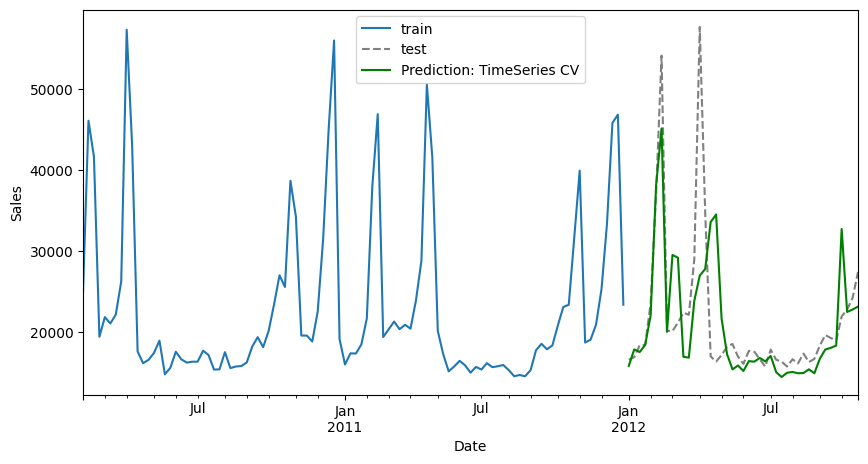

In [80]:
# Plot
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))

data_train.plot(x='Date', y='Weekly_Sales', label='train', ax=ax)
data_test.plot(x='Date', y='Weekly_Sales', c='grey', linestyle='--', label='test', ax=ax)
data_test_pred.plot(x='Date', y='Weekly_Sales', c='green', label='Prediction: TimeSeries CV', ax=ax)

ax.set_ylabel('Sales')
plt.legend()
plt.show()

In [395]:
ts_cv = mean_absolute_percentage_error(y_test, y_test_pred)
kf_cv = mean_absolute_percentage_error(y_test, y_test_gs_pred)
ts_cv, kf_cv

(0.20927012600345582, 0.21424859750089476)